<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Probability_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 13.9 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [15]:
from  pyod.models.ecod import ECOD
model = ECOD(contamination=0.000000001)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []

  for i in stage:
    model = ECOD(contamination=0.000000001)
    model.fit(train_scale[i])

    train_score = model.decision_scores_
    test_score = model.decision_function(test_scale[i])

    test_scores.append(test_score)
    train_scores.append(train_score)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores


In [17]:
stage = [P1,P2,P3,P4,P5,P6]

In [18]:
norm_test_scores,test_scores,train_scores,norm_train_scores = get_test_score(stage,train_scale,test_scale)

------ Finish Stage ['FIT101', 'LIT101', 'MV101', 'P101', 'P102'] ------
------ Finish Stage ['AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206'] ------
------ Finish Stage ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302'] ------
------ Finish Stage ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401'] ------
------ Finish Stage ['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503'] ------
------ Finish Stage ['FIT601', 'P601', 'P602', 'P603'] ------


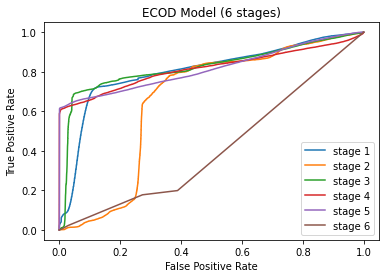

In [133]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'ECOD Model (6 stages)')
  plt.legend(loc=4)

In [131]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}")

AUC stage1: 0.805
AUC stage2: 0.657
AUC stage3: 0.824
AUC stage4: 0.818
AUC stage5: 0.816
AUC stage6: 0.413


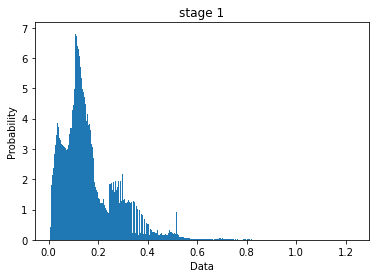

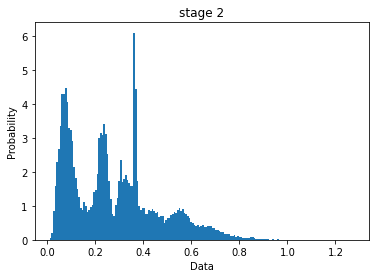

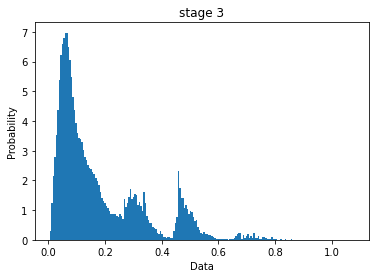

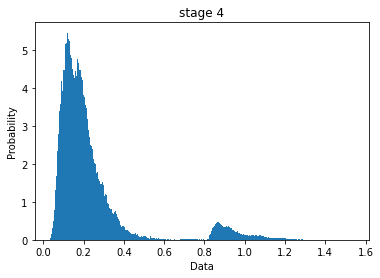

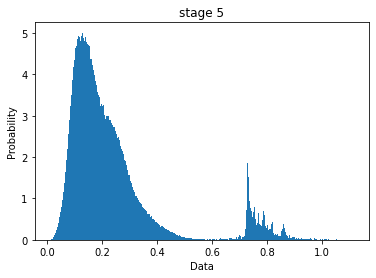

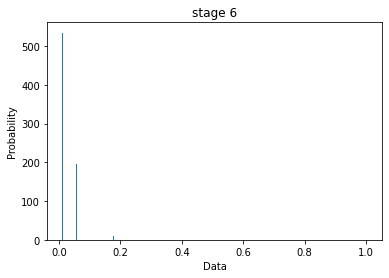

In [144]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins='auto')  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

In [171]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [21]:
time_window = 10

##Ture Attack point

In [28]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [45]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [58]:
true_attack.tail(3)

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
38,39,2/01/2015 11:43:48,11:50:28,"FIT-401, AIT-502",In Normal Range,Set value of FIT-401 as 0.5; Set value of AIT-...,No,UV will shut down and water will go to RO,UV did not shutdown
39,40,2/01/2015 11:51:42,11:56:38,FIT-401,In Normal Range,Set value of FIT-401 as 0,No,UV will shut down and water will go to RO,"P-402 did not close, both should be interlinked"
40,41,2/01/2015 13:13:02,13:40:56,LIT-301,Water level between L and H,decrease value by 0.5 mm per second,No,Tank overflow,Rate of decrease in water level reduced after ...


In [59]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [60]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [61]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [62]:
len(start_time) #there are 36 attack

36

In [53]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [77]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [80]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [79]:
idx_start

array([  1754,   3068,   4920,   6459,   7255,   7705,  11410,  15380,
        15540,  90685,  92140,  93445, 103092, 115843, 116143, 117000,
       132918, 142954, 172268, 172910, 198296, 227828, 229519, 279120,
       280060, 302653, 347679, 361191, 371479, 371855, 389680, 436541,
       437417, 438147, 438621, 443501])

In [81]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##Stage P1

In [106]:
t1 = np.percentile(norm_test_scores[0],90)

In [107]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [125]:
time_label["pred_1"] = label_1

In [123]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

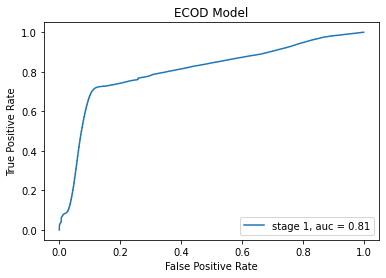

In [129]:
fpr, tpr, _ = metrics.roc_curve(label, norm_test_scores[0])
auc = metrics.roc_auc_score(label, norm_test_scores[0])
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [135]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89    395298
           1       0.35      0.57      0.44     54621

    accuracy                           0.82    449919
   macro avg       0.64      0.71      0.66    449919
weighted avg       0.86      0.82      0.84    449919



In [219]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 21 26 30 33 34 35 36]


In [220]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [202]:
t2 = np.percentile(norm_test_scores[1],90)

In [203]:
t2

0.5536130346204002

In [204]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [212]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88    395298
           1       0.06      0.05      0.05     54621

    accuracy                           0.78    449919
   macro avg       0.46      0.47      0.47    449919
weighted avg       0.77      0.78      0.78    449919



In [207]:
time_label["pred_2"] = label_2

In [221]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [223]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[24]


##Stage P3

In [224]:
t3 = np.percentile(norm_test_scores[2],90)

In [225]:
t3

0.46085872462594535

In [226]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [227]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    395298
           1       0.65      0.64      0.65     54621

    accuracy                           0.92    449919
   macro avg       0.80      0.80      0.80    449919
weighted avg       0.91      0.92      0.91    449919



In [228]:
time_label["pred_3"] = label_3

In [229]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [230]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 8 17 23 26 28 41]


##Stage P4

In [233]:
t4 = np.percentile(norm_test_scores[3],90)

In [234]:
t4

0.38412817027080626

In [235]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [236]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    395298
           1       0.68      0.63      0.65     54621

    accuracy                           0.92    449919
   macro avg       0.81      0.79      0.80    449919
weighted avg       0.92      0.92      0.92    449919



In [237]:
time_label["pred_4"] = label_4

In [238]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [239]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[10 11 22 25 40]


##Stage P5

In [241]:
t5 = np.percentile(norm_test_scores[4],90)

In [242]:
t5

0.3948892484009113

In [243]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [244]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    395298
           1       0.65      0.65      0.65     54621

    accuracy                           0.91    449919
   macro avg       0.80      0.80      0.80    449919
weighted avg       0.91      0.91      0.91    449919



In [245]:
time_label["pred_5"] = label_5

In [248]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [249]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[20 22 37 38 39]


##Stage P6

In [283]:
t6 = np.percentile(norm_test_scores[5],90)

In [284]:
t6

0.177549398921028

In [285]:
label_6 = pred_labels_timewindow(norm_test_scores[5],t6,time_window)

In [286]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    395298
           1       0.10      0.03      0.05     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



In [287]:
time_label["pred_6"] = label_6

In [289]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [291]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


##Attack found

In [296]:
pred_all = time_label[['pred_1',	'pred_2',	'pred_3',	'pred_4',	'pred_5',	'pred_6']].to_numpy()

In [318]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [322]:
found = []
for i in range(len(time_label)):
  if (time_label.iloc[i]["pred"] == 1) & (time_label.iloc[i]["label"] == 1):
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  4  8 10 11 13 14 17 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41]


In [325]:
len(np.unique(found))-1 #remove 0

33